# Singular Value Decomposition

Let’s talk about SVD.

:::{note}
This is a casual introduction so could be inaccurate.
:::

First, why do we want SVD?

Let's watch from a geometric perspective (courtesy [this blog](http://www.ams.org/publicoutreach/feature-column/fcarc-svd))

Imagine a box of size $(1, 1)$ is put on a 2D coordinate frame:

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_formats = ['retina']

In [15]:
import sympy
from sympy import Matrix
sympy.init_printing(use_latex="mathjax")

In [16]:
v = np.array([[0, 1, 1, 0], [0, 0, 1, 1]]) # A square box
M = np.array([[1, 1], [0, 1]]) # A linear transform

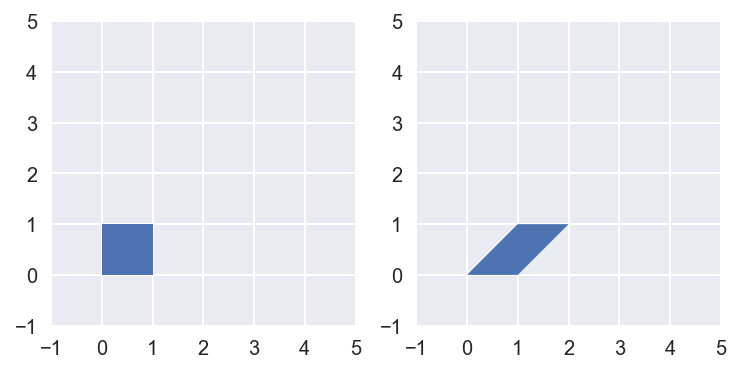

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
def plot_boxes(fig, axs, v0, Mv0):
    _ = [ax.set_xlim(-1, 5) for ax in axs]
    _ = [ax.set_ylim(-1, 5) for ax in axs]
    _ = [ax.xaxis.set_major_locator(plt.MultipleLocator(1.0)) for ax in axs]
    _ = [ax.set_aspect("equal") for ax in axs]
    axs[0].fill(v0[0], v0[1])
    axs[1].fill(Mv0[0], Mv0[1])
plot_boxes(fig, axs, v, M @ v)
fig.show()

What does the eigenvalues and eigenvectors tell us? Well here it is:

In [18]:
(D, X) = np.linalg.eig(M)
(Matrix(D), Matrix(X))

⎛⎡1.0⎤  ⎡1.0          -1.0        ⎤⎞
⎜⎢   ⎥, ⎢                         ⎥⎟
⎝⎣1.0⎦  ⎣0.0  2.22044604925031e-16⎦⎠

The only result from this is that the direction for a vector is preserved only when it's a multiple of $(1, -1)$, which is demonstrated by

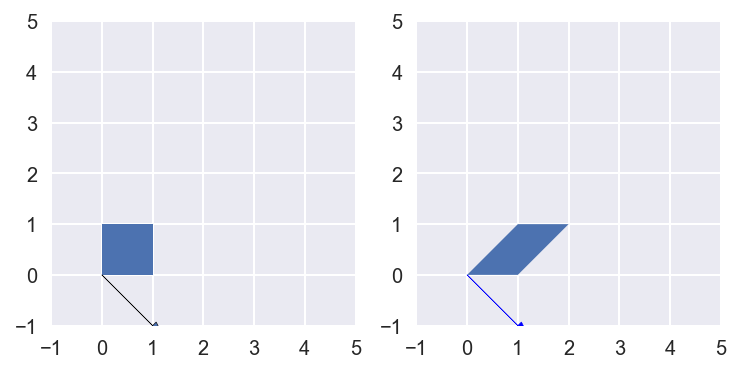

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_boxes(fig, axs, v, M @ v)
axs[0].arrow(0, 0, X[0,0], X[0,1], head_width=0.2)
axs[1].arrow(0, 0, (M @ X)[0,0], (M @ X)[0,1], head_width=0.2, color="b")
fig.show()

We would then wonder: is there a better way to characterize the *effect* of a linear transformation? 

Turns out there is. Let's try rotating the box and observe the result:

In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [21]:
def dynamic_tranform_effect(angle: float):
    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_boxes(fig, axs, R @ v, M @ R @ v)
    axs[0].arrow(0, 0, (R @ v)[0,3], (R @ v)[1,3], head_width=0.2, color='r')
    axs[0].arrow(0, 0, (R @ v)[0,1], (R @ v)[1,1], head_width=0.2, color='r')
    axs[1].arrow(0, 0, (M @ R @ v)[0,3], (M @ R @ v)[1,3], head_width=0.2, color='r')
    axs[1].arrow(0, 0, (M @ R @ v)[0,1], (M @ R @ v)[1,1], head_width=0.2, color='r')
    plt.show()
interact(dynamic_tranform_effect, angle=widgets.FloatSlider(min=-1.5,max=1.5,step=0.05,value=1.05));

interactive(children=(FloatSlider(value=1.05, description='angle', max=1.5, min=-1.5, step=0.05), Output()), _…

For readers not using the Jupyter version, here is the plot at optimum:

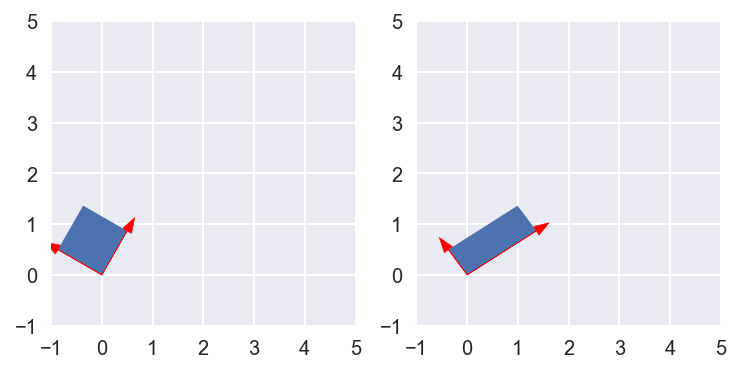

In [22]:
dynamic_tranform_effect(1.05)

We can see clearly that the box is still a box after the transform $M$. More formally, this means that the two vectors are still orthogonal after $M$:
\begin{align}
    (Mv_1)^T(Mv_2) = 0
\end{align}

Similar to the notation for eigenvalues, we denote $Mv_1 = \sigma_1 u_1$, $Mv_2 = \sigma_2 u_2$, thus for any vector $v$, we have
\begin{equation}
    v = (v_1^Tv)v_1 + (v_2^Tv) v_2
\end{equation}

\begin{equation}
    Mv = \sigma_1 u_1 v_1^Tv + \sigma_2 u_2 v_2^Tv
    \label{eq_svd_2d}
\end{equation}

Since the above equation works for any $v$, we have
\begin{equation}
    M = u_1 \sigma_1  v_1^T + u_2 \sigma_2 v_2^T
\end{equation}

In a more modern form:

(svd_def)=
```{proof:definition} SVD
$$
    M = U\Sigma V^T
$$
```

Since $\sigma_i$ and $v_i$ are all unit orthogonal, we know that $U$ and $V$ are unitary.


Now the problem is, how can we calculate the SVD ({numref}`svd_def`) of $M$?

An approach (Trefethen and Bau) is to consider the following symmetric matrix:
\begin{equation}
    \tilde A=\begin{bmatrix}
        0 & A^T \\
        A & 0
    \end{bmatrix}
\end{equation}

which has an eigendecomposition of
\begin{equation}
    \tilde A=\begin{bmatrix}
        V & V \\
        U & -U
    \end{bmatrix}\begin{bmatrix}
        \Sigma & 0 \\
        0 & -\Sigma
    \end{bmatrix}\begin{bmatrix}
        V & V \\
        U & -U
    \end{bmatrix}^{-1}
\end{equation}

We can try the above procedure with sympy:

In [81]:
import sympy as sp
M_s = sp.Matrix([[1, 1], [0, 1]])
M_tlide = sp.Matrix(sp.BlockMatrix([[sp.ZeroMatrix(2, 2), M_s.T], [M_s, sp.ZeroMatrix(2, 2)]]))
M_tlide

⎡0  0  1  0⎤
⎢          ⎥
⎢0  0  1  1⎥
⎢          ⎥
⎢1  1  0  0⎥
⎢          ⎥
⎣0  1  0  0⎦

In [82]:
Q, L = M_tlide.diagonalize()
Q, L

⎛                                      ⎡  1   √5                          ⎤⎞
⎜                                      ⎢- ─ + ──    0       0        0    ⎥⎟
⎜⎡   -1       1       1        -1   ⎤  ⎢  2   2                           ⎥⎟
⎜⎢                                  ⎥  ⎢                                  ⎥⎟
⎜⎢  1   √5  1   √5  1   √5    √5   1⎥  ⎢          1   √5                  ⎥⎟
⎜⎢- ─ + ──  ─ - ──  ─ + ──  - ── - ─⎥  ⎢   0      ─ - ──    0        0    ⎥⎟
⎜⎢  2   2   2   2   2   2     2    2⎥  ⎢          2   2                   ⎥⎟
⎜⎢                                  ⎥, ⎢                                  ⎥⎟
⎜⎢ 1   √5   1   √5  1   √5   1   √5 ⎥  ⎢                  1   √5          ⎥⎟
⎜⎢ ─ - ──   ─ - ──  ─ + ──   ─ + ── ⎥  ⎢   0        0     ─ + ──     0    ⎥⎟
⎜⎢ 2   2    2   2   2   2    2   2  ⎥  ⎢                  2   2           ⎥⎟
⎜⎢                                  ⎥  ⎢                                  ⎥⎟
⎜⎣   1        1       1        1    ⎦  ⎢                            √5   1⎥⎟

In [83]:
sigma_1, sigma_2 = M_s.singular_values()

In [84]:
sp.sqrtdenest(sigma_1).simplify(), sp.sqrtdenest(sigma_2).simplify()

⎛1   √5    1   √5⎞
⎜─ + ──, - ─ + ──⎟
⎝2   2     2   2 ⎠

Immediate we see that the eigenvalues of $A$ are the absolute values of the eigenvalues of $\tilde A$, which happens to be the Golden Ratio!

However this still does not immediately give us the SVD, since the eigendecomposition is not unique. We need to rearrange the result.

